# Проект: "Исследовательский анализ данных в Python и проверка гипотез"

####  Дата проекта: 29.05.2025г.   
####  Автор :Бурыкина Е.А.

## Введение

### Цель проекта: анализ данных, чтобы выявить инсайты об изменении пользовательских предпочтений и популярности событий осенью 2024 года, а также проверить гипотезы о разнице в поведении пользователей с мобильными и стационарными устройствами.

### Задачи проекта   

Ответить на вопросы:   

-понять причины изменения пользовательского спроса;   
-повлиял ли на это фактор сезонности;   
-как изменилась аудитория;    
-какие события привлекают больше внимания пользователей;    
-какие организаторы и площадки в лидерах;    
-понять, отличаются ли своей активностью пользователи мобильных устройств от клиентов, которые бронируют билеты со стационарного компьютера(проверка гипотезы)

##### Знакомство с данными:   

Данные о бронировании билетов на сервисе Яндекс Афиша за период с 1 июня по 30 октября 2024 года.    

Данные в виде 3 датасетов: `final_tickets_orders_df.csv`,`final_tickets_events_df.csv`,`final_tickets_tenge_df.csv`.     

- `final_tickets_orders_df.csv` - датасет включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных.     

- `final_tickets_events_df.csv`-содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия.    

- `final_tickets_tenge_df.csv`- с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге.

##### Описание данных:   

Датасет `final_tickets_orders_df.csv`:   

- `order_id` — уникальный идентификатор заказа.  
- `user_id` — уникальный идентификатор пользователя.  
- `created_dt_msk` — дата создания заказа (московское время).  
- `created_ts_msk` — дата и время создания заказа (московское время).  
- `event_id` — идентификатор мероприятия из таблицы events.  
- `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.  
- `age_limit` — возрастное ограничение мероприятия.  
- `currency_code` — валюта оплаты, например rub для российских рублей.  
- `device_type_canonical` — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.  
- `revenue` — выручка от заказа.  
- `service_name` — название билетного оператора.  
- `tickets_count` — количество купленных билетов.  
- `total` — общая сумма заказа.  
- `days_since_prev`- с количеством дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.  

Второй датасет `final_tickets_events_df.csv` содержит такие поля:  

- `event_id` — уникальный идентификатор мероприятия.  
- `event_name` — название мероприятия. Аналог поля event_name_code из исходной базы данных.  
- `event_type_description` — описание типа мероприятия.  
- `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее.  
- `organizers` — организаторы мероприятия.  
- `region_name` — название региона.  
- `city_name` — название города.  
- `venue_id` — уникальный идентификатор площадки.  
- `venue_name` — название площадки.  
- `venue_address` — адрес площадки.  

Датасет `final_tickets_tenge_df.csv` содержит такие поля:  

- `nominal` — номинал (100 тенге).  
- `data` — дата.  
- `curs` — курс тенге к рублю.  
- `cdx` — обозначение валюты (kzt).  

## Загрузка данных и знакомство с ними

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import levene

In [2]:
df_orders = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')
df_events = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
df_tenge = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [3]:
dfs = {'df_orders': df_orders,
       'df_events':df_events,
       'df_tenge':df_tenge}

In [4]:
def lookup_datasets(dfs, filenames=None):
    """
    Выводит информацию о датасетах из списка

    Parameters:
        dfs (list of pd.DataFrame): Список датафреймов для обработки.
        filenames (list of str): Список названий файлов (имена для отображения).
    """
    if filenames is None:
        filenames = [f"df_{i + 1}" for i in range(len(dfs))]

    for df, df_name in zip(dfs, filenames):
        print('-'*10,' '*5, df_name, ' '*5, '-'*10)

        # Пропущенные значения
        missing_data = df.isna().mean()
        missing_data_result = missing_data.apply(lambda x: f'{x:.2%}' if x > 0 else "")
        missing_data_name = "Пропущено" if missing_data.sum() > 0 else ""
        missing_data_result.name = missing_data_name

        # Типы данных
        dtypes_result = df.dtypes
        dtypes_result.name = "Тип данных колонки"
        fewest_nans_row = df.iloc[1:-1].isna().sum(axis=1).idxmin()

        values_type = df.loc[fewest_nans_row].map(type).T
        values_type.name = "Тип значения"

        # Объединяем результаты и пример данных
        result = pd.concat([
            dtypes_result, # типы
            values_type, # типы значений
            missing_data_result, # пропущенные значения
            df.iloc[0, :], # первая строка
            df.loc[fewest_nans_row].T, # полная строка
            df.iloc[-1, :] # последняя строка
        ], axis=1)

        display(result)

        # Проверка на полные дубликаты
        duplicates = df.duplicated().mean()
        if duplicates > 0:
            print(f'Полных дубликатов: {duplicates:.2%}')
        else:
            print('Полных дубликатов нет.')

        print()

 # Проводим автоматический осмотр данных
column_counts = lookup_datasets(dfs.values(), dfs.keys())

----------       df_orders       ----------


,Тип данных колонки,Тип значения,Пропущено,0,2,290848
order_id,int64,<class 'numpy.int64'>,,4359165,7292370,813654
user_id,object,<class 'str'>,,0002849b70a3ce2,0005ca5e93f2cf4,ffff00725179321
created_dt_msk,object,<class 'str'>,,2024-08-20,2024-10-06,2024-09-25
created_ts_msk,object,<class 'str'>,,2024-08-20 16:08:03,2024-10-06 13:56:02,2024-09-25 15:12:40
event_id,int64,<class 'numpy.int64'>,,169230,578454,284965
cinema_circuit,object,<class 'str'>,,нет,нет,нет
age_limit,int64,<class 'numpy.int64'>,,16,0,16
currency_code,object,<class 'str'>,,rub,rub,rub
device_type_canonical,object,<class 'str'>,,mobile,mobile,mobile
revenue,float64,<class 'numpy.float64'>,,1521.94,1258.57,802.25


Полных дубликатов нет.

----------       df_events       ----------


,Тип данных колонки,Тип значения,,0,1,22426
event_id,int64,<class 'numpy.int64'>,,4436,5785,592325
event_name,object,<class 'str'>,,e4f26fba-da77-4c61-928a-6c3e434d793f,5cc08a60-fdea-4186-9bb2-bffc3603fb77,f4952452-27ff-4d03-9adb-f7836430f83b
event_type_description,object,<class 'str'>,,спектакль,спектакль,событие
event_type_main,object,<class 'str'>,,театр,театр,другое
organizers,object,<class 'str'>,,№4893,№1931,№3884
region_name,object,<class 'str'>,,Североярская область,Светополянский округ,Яблоневская область
city_name,object,<class 'str'>,,Озёрск,Глиноград,Светополье
city_id,int64,<class 'numpy.int64'>,,2,54,39
venue_id,int64,<class 'numpy.int64'>,,1600,2196,1081
venue_name,object,<class 'str'>,,"Кладбище искусств ""Проблема"" и партнеры","Лекции по искусству ""Свет"" Групп","Искусственная сцена ""Краски"" и партнеры"


Полных дубликатов нет.

----------       df_tenge       ----------


,Тип данных колонки,Тип значения,,0,1,356
data,object,<class 'str'>,,2024-01-10,2024-01-11,2024-12-31
nominal,int64,<class 'numpy.int64'>,,100,100,100
curs,float64,<class 'numpy.float64'>,,19.9391,19.7255,19.486
cdx,object,<class 'str'>,,kzt,kzt,kzt


Полных дубликатов нет.



#### Предварительный вывод   

`df_orders` - содержит 290848 строк, 14 столбцов.   
Данные в столбцах `created_dt_msk`, `created_ts_msk` представлены типом `object`, что будет рациональным поменять на тип `datetime`, так как в данных столбцах содержится информация о дате и времени создания заказа.   
Остальные данные представлены а правильно типе данных.   
Пропуски содержатся в столбце `days_since_prev` и составляют 7,54%.   

`df_events` - содержит 22427 строк и 11 столбцов. Данные представлены в правильных типах данных.   
Пропусков нет.

`df_tenge` -содержит 356 строк и 4 столбца. Столбец `data` представлен типом `object`, но содержит информацию о дате. Будет правильнее изменить тип данных на `datetime`.   
пропусков нет.

In [5]:
df = df_orders.merge(df_events, how='left')

In [6]:
df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4"
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6"
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8"
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8"


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290849 non-null  int64  
 1   user_id                 290849 non-null  object 
 2   created_dt_msk          290849 non-null  object 
 3   created_ts_msk          290849 non-null  object 
 4   event_id                290849 non-null  int64  
 5   cinema_circuit          290849 non-null  object 
 6   age_limit               290849 non-null  int64  
 7   currency_code           290849 non-null  object 
 8   device_type_canonical   290849 non-null  object 
 9   revenue                 290849 non-null  float64
 10  service_name            290849 non-null  object 
 11  tickets_count           290849 non-null  int64  
 12  total                   290849 non-null  float64
 13  days_since_prev         268909 non-null  float64
 14  event_name          

## Предобработка данных на наличие пропусков и дубликатов.

In [8]:
df.columns

Index(['order_id', 'user_id', 'created_dt_msk', 'created_ts_msk', 'event_id',
       'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
       'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
       'event_name', 'event_type_description', 'event_type_main', 'organizers',
       'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name',
       'venue_address'],
      dtype='object')

In [9]:
df.isna().sum()/len(df)*100

,0
order_id,0.000000
user_id,0.000000
created_dt_msk,0.000000
created_ts_msk,0.000000
event_id,0.000000
cinema_circuit,0.000000
age_limit,0.000000
currency_code,0.000000
device_type_canonical,0.000000
revenue,0.000000


#### Предварительный вывод:   
Пропуски содержатся в 12 столбцах. Столбец `days_since_prev`содержит информацию о количестве дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск. Данные пропуски оставим.    
Пропуски в остальных столбцах составляют лишь 0,8%, их можно удалить.

In [10]:
df = df.dropna(subset=['event_name','event_type_description','event_type_main','organizers','region_name','city_name','city_id','venue_id','venue_name','venue_address'])

In [11]:
df['created_dt_msk'] = df['created_dt_msk'].astype('datetime64[ns]')

<ipython-input-11-8e54c0f182de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['created_dt_msk'] = df['created_dt_msk'].astype('datetime64[ns]')


In [12]:
df['created_ts_msk'] = df['created_ts_msk'].astype('datetime64[ns]')

In [13]:
df.duplicated().sum()

np.int64(0)

In [14]:
df_g = df.groupby('cinema_circuit')['order_id'].count().sort_values().reset_index()
df_g_2 = df.groupby('age_limit')['order_id'].count().sort_values().reset_index()
df_g_3 = df.groupby('device_type_canonical')['order_id'].count().sort_values().reset_index()
df_g_4 = df.groupby('service_name')['order_id'].count().sort_values().reset_index()
df_g_5 = df.groupby('event_type_description')['order_id'].count().sort_values().reset_index()
df_g_6 = df.groupby('event_type_main')['order_id'].count().sort_values().reset_index()
print(f'Распределение по сети кинотеатров:\n{df_g}\n')
print("-" * 30)
print(f'Распределение по возрасту:\n{df_g_2}\n')
print("-" * 30)
print(f'Распределение по типам устройств:\n{df_g_3}\n')
print("-" * 30)
print(f'Распределение по названию оператора:\n{df_g_4}\n')
print("-" * 30)
print(f'Распределение по описанию мероприятия:\n{df_g_5}\n')
print("-" * 30)
print(f'Распределение по основному типу мероприятия:\n{df_g_6}\n')

Распределение по сети кинотеатров:
  cinema_circuit  order_id
0     ЦентрФильм         1
1        Москино         7
2       Киномакс         7
3       КиноСити       122
4         Другое      1261
5            нет    289213

------------------------------
Распределение по возрасту:
   age_limit  order_id
0         18     35933
1          6     52161
2          0     61487
3         12     62474
4         16     78556

------------------------------
Распределение по типам устройств:
  device_type_canonical  order_id
0               desktop     58121
1                mobile    232490

------------------------------
Распределение по названию оператора:
              service_name  order_id
0       Билеты в интернете         4
1                 Зе Бест!         5
2                   Лимоны         8
3                Тех билет        22
4             Цвет и билет        61
5               Кино билет        67
6                  Дырокол        74
7                  Вперёд!        80
8        

####  "нет информации" в категории сети кинотеатров может означать, что в данных присутствует категория, которая не соответствует ни одной из известных сетей кинотеатров. Это может быть связано с несколькими факторами:     
- 1)Значение "нет" может указывать на то, что пользователи не выбрали сеть кинотеатров при оформлении заказа       
- 2)Значение "нет" может быть результатом ошибок при сборе данных, например, если система не смогла корректно идентифицировать сеть кинотеатров.

In [15]:
df_without_id = df.drop(columns=['order_id'])

duplicates = df_without_id[df_without_id.duplicated(keep=False)]

num_duplicates = duplicates.shape[0]
print(f"Количество неявных дубликатов: {num_duplicates}")


Количество неявных дубликатов: 58


In [16]:
df['tickets_count'].describe()

,tickets_count
count,290611.000000
mean,2.754311
std,1.170620
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,57.000000


In [17]:
anomalous_tickets = df[df['tickets_count'] == 57][['user_id', 'tickets_count','revenue','total']]
print(anomalous_tickets)

                user_id  tickets_count  revenue  total
154138  7eb4fc207ecc10f             57      0.0    0.0


#### Мы видим ,что в столбце о количестве проданных билетов есть аномальные значения. При анализе видим,что прибыли от продажи не было, графа содержит "0". Данное значение аномальное,поэтому мы избавляемся от данных значений.

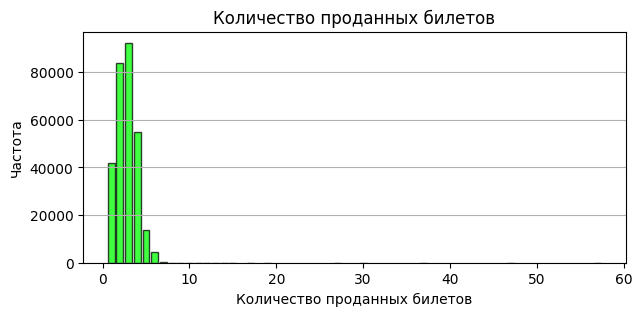

In [18]:
ticket_counts = df['tickets_count'].value_counts().sort_index()
plt.figure(figsize=(7, 3))
plt.bar(ticket_counts.index, ticket_counts.values, color='lime', edgecolor='black', alpha=0.75)

plt.title('Количество проданных билетов')
plt.xlabel('Количество проданных билетов')
plt.ylabel('Частота')

plt.grid(axis='y')

plt.show()

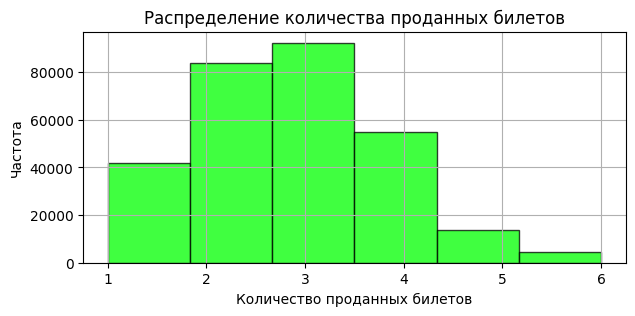

In [19]:
df_gr = df[df['tickets_count'] <= df['tickets_count'].quantile(0.99)]['tickets_count']

plt.figure(figsize=(7, 3))

# Строим гистограмму с помощью pandas через plot(kind='hist')
df_gr.plot(
                kind='hist', # Тип графика - гистограмма
                bins=6, # Устанавливаем количество корзин
                alpha=0.75,
                color = 'lime',
                edgecolor='black',
)

# Настраиваем оформление графика
plt.title('Распределение количества проданных билетов')
plt.xlabel('Количество проданных билетов')
plt.ylabel('Частота')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

In [20]:
df = df[df['tickets_count']<= df['tickets_count'].quantile(0.99)]
df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4"
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6"
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8"
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8"


In [21]:
df_1 = df[df['currency_code']=='rub'].copy()
df_2 = df[df['currency_code']=='kzt'].copy()

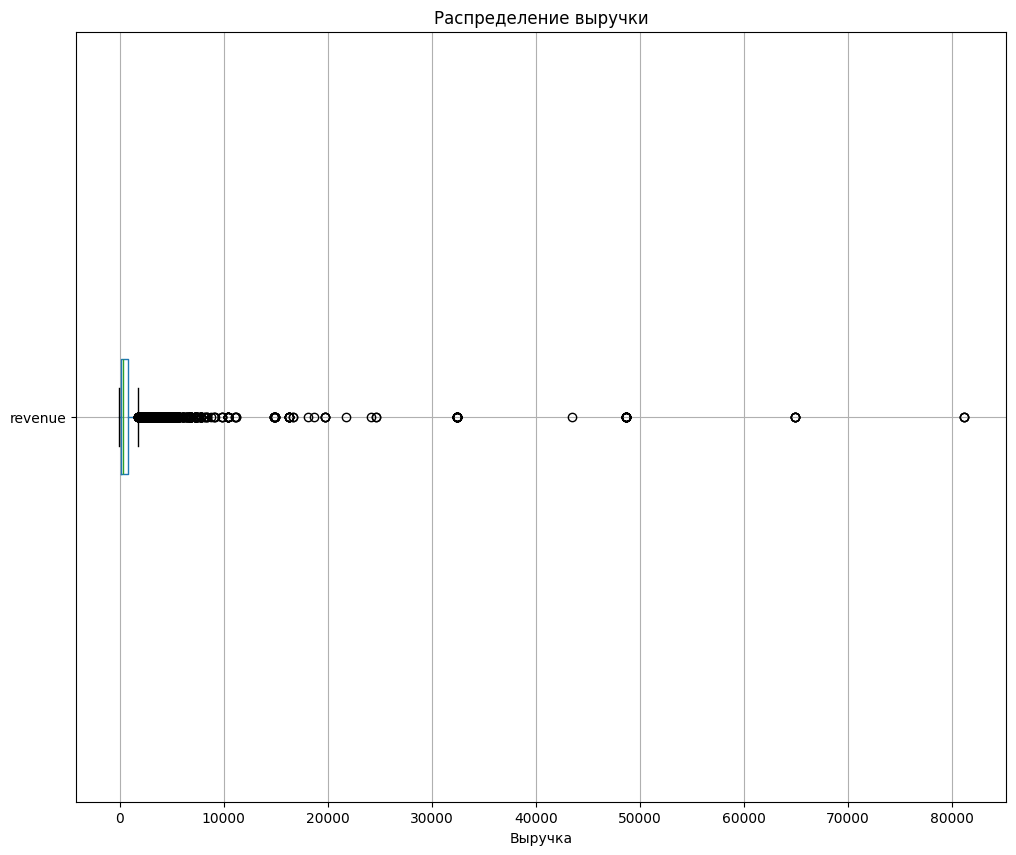

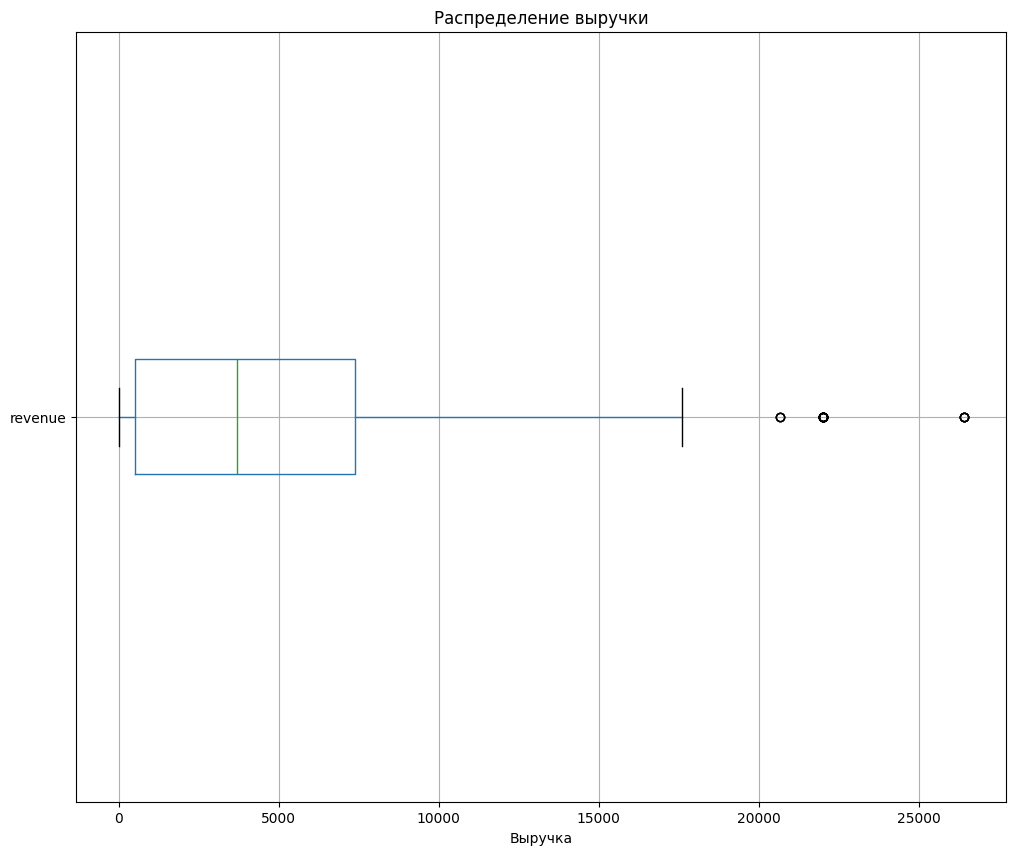

In [22]:
boxplot = df_1.boxplot(column='revenue',
                     vert=False,
                     figsize=(12, 10))

# Добавляем заголовок и метку оси X
boxplot.set_title('Распределение выручки')
boxplot.set_xlabel('Выручка')

plt.show()

boxplot = df_2.boxplot(column='revenue',
                     vert=False,
                     figsize=(12, 10))

# Добавляем заголовок и метку оси X
boxplot.set_title('Распределение выручки')
boxplot.set_xlabel('Выручка')

plt.show()

##### По предварительному анализу, в данных о выручку содержится очень много аномальных значений. Есть значения отрицательные. Посмотрим их распределение после корректировки столбца.

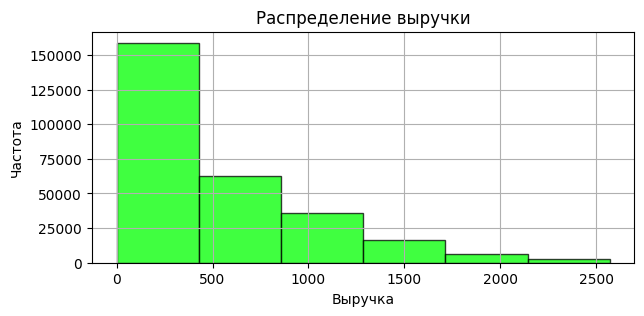

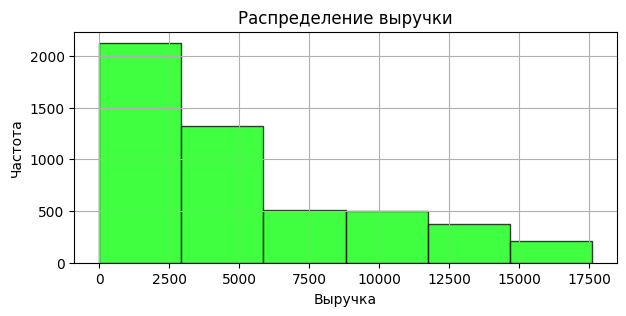

In [23]:
df_gr_1 = df_1[(df_1['revenue'] <= df_1['revenue'].quantile(0.99))&(df_1['revenue']>=0)]['revenue']

plt.figure(figsize=(7, 3))

# Строим гистограмму с помощью pandas через plot(kind='hist')
df_gr_1.plot(
                kind='hist', # Тип графика - гистограмма
                bins=6, # Устанавливаем количество корзин
                alpha=0.75,
                color = 'lime',
                edgecolor='black',
)

# Настраиваем оформление графика
plt.title('Распределение выручки')
plt.xlabel('Выручка')
plt.ylabel('Частота')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

df_gr_2 = df_2[(df_2['revenue'] <= df_2['revenue'].quantile(0.99))&(df_2['revenue']>=0)]['revenue']

plt.figure(figsize=(7, 3))

# Строим гистограмму с помощью pandas через plot(kind='hist')
df_gr_2.plot(
                kind='hist', # Тип графика - гистограмма
                bins=6, # Устанавливаем количество корзин
                alpha=0.75,
                color = 'lime',
                edgecolor='black',
)

# Настраиваем оформление графика
plt.title('Распределение выручки')
plt.xlabel('Выручка')
plt.ylabel('Частота')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

In [24]:
a = df_gr_1.count()/df_1['revenue'].count()
print(f' Отношение аномальных значений по отношению к общему количеству заказов равно:{round(a,2)}')

 Отношение аномальных значений по отношению к общему количеству заказов равно:0.99


#### Так как аномально высокие значения составляют менее одного процента от общего числа покупок, будет рационально их удалить. После корректировки среднее значение и медианы практически равны. На графиках мы видим длинный правый хвост и высокую концентрацию покупок низкой стоимости - распределение значений не нормальное.

In [25]:
anomalous_values = df_1[df_1['revenue']>40000][['user_id','revenue','tickets_count','total','currency_code','event_type_main']].reset_index()
display(anomalous_values.head(10))

,index,user_id,revenue,tickets_count,total,currency_code,event_type_main
0,11139,061b378a1519041,48704.72,3,487047.22,rub,концерты
1,28970,0ea528819041df1,48704.72,3,487047.22,rub,концерты
2,50535,1e814c3bab7d73a,48704.72,3,487047.22,rub,концерты
3,51395,1f49b8de206b285,48704.72,3,487047.22,rub,концерты
4,78660,39e9388e79faf29,43515.08,2,395591.62,rub,концерты
5,99245,48e7ffaf53cc37b,48704.72,3,487047.22,rub,концерты
6,107137,4ec8f6429431987,48704.72,3,487047.22,rub,концерты
7,111591,5245e419c5ac876,48704.72,3,487047.22,rub,концерты
8,111593,5245e419c5ac876,64939.63,4,649396.30,rub,концерты
9,111594,5245e419c5ac876,48704.72,3,487047.22,rub,концерты


In [26]:
anomalous_values_2 = df_2[df_2['revenue']>20000][['user_id','revenue','tickets_count','total','currency_code','event_type_main']].reset_index()
display(anomalous_values_2.head(10))

,index,user_id,revenue,tickets_count,total,currency_code,event_type_main
0,289,00f4f5244501ce6,22021.55,5,275269.4,kzt,концерты
1,822,019fa401ddb00aa,22021.55,5,275269.4,kzt,концерты
2,3340,02ea4583333f064,20676.39,6,344606.5,kzt,концерты
3,11304,066dbc1c7d3b89c,22021.55,5,275269.4,kzt,концерты
4,15064,0beb8fc0c0a9ce1,20676.39,6,344606.5,kzt,концерты
5,68863,2fff690c8383fd9,22021.55,5,275269.4,kzt,концерты
6,89247,40681fd66855996,26425.86,6,330323.3,kzt,концерты
7,89248,40681fd66855996,26425.86,6,330323.3,kzt,концерты
8,101624,4c3dc66e884d310,22021.55,5,275269.4,kzt,концерты
9,101625,4c3dc66e884d310,22021.55,5,275269.4,kzt,концерты


#### По предварительному анализу мы видим,что аномально высокие значения выручки в обеих валютых содержат информацию о покупке билетов в количестве от 4 до 6 шт на концерты. Данная информация может быть ревльной,так как стоимость билета на концерт зависит от места проведения и ряда. Данные значения, я считаю необходимо оставить и не удалять. Они пригодятся для последующего анализа.  Стоимость билетов отрицательного значения необходимо удалить.

In [27]:
df = df[df['revenue']>0]

In [28]:
df_new = pd.concat([df_1, df_2], ignore_index=True)

In [30]:
df_tenge['data'] = df_tenge['data'].astype('datetime64[ns]')

In [31]:
df_m = df_new.merge(df_tenge,left_on='created_dt_msk', right_on='data')

In [32]:
df_m['revenue_rub'] = df_m['revenue']

df_m.loc[df_m['currency_code'] == 'kzt', 'revenue_rub'] = (df_m['revenue'] * df_m['nominal'] / df_m['curs'])

In [33]:
df_m['one_ticket_revenue_rub'] = df_m['revenue']/df_m['tickets_count']
df_m['month'] = df_m['created_dt_msk'].dt.month.fillna(0).astype(int)

In [34]:
def m_season(month):
    if month in [12, 1, 2]:
        return 'зима'
    elif month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    elif month in [9, 10, 11]:
        return 'осень'

df_m['season'] = df_m['month'].apply(m_season)


In [35]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290423 entries, 0 to 290422
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290423 non-null  int64         
 1   user_id                 290423 non-null  object        
 2   created_dt_msk          290423 non-null  datetime64[ns]
 3   created_ts_msk          290423 non-null  datetime64[ns]
 4   event_id                290423 non-null  int64         
 5   cinema_circuit          290423 non-null  object        
 6   age_limit               290423 non-null  int64         
 7   currency_code           290423 non-null  object        
 8   device_type_canonical   290423 non-null  object        
 9   revenue                 290423 non-null  float64       
 10  service_name            290423 non-null  object        
 11  tickets_count           290423 non-null  int64         
 12  total                   290423

#### После обработки данных наш датафрейм содержит 284 389 строк и 31 столбец.     
Данные преобразованы, добавлены новые столбцы.   
Новые столбцы:
- `revenue_rub` — приведение выручки с заказа к единой валюте — российскому рублю.   
- `one_ticket_revenue_rub` — выручка с продажи одного билета на мероприятие.   
- `month` —  месяц оформления заказа .   
- `season` — информация о сезонности.   

 Изначально у нас было 290 848 строк. После предобработки данных датафрейм сократился на 6 326 строк,что составляет примерно 2 %.

### Часть 3. Исследовательский анализ данных.

### Анализ распределения заказов по сегментам и их сезонные изменения

In [36]:
df_agg = df_m.groupby('month')['order_id'].count()

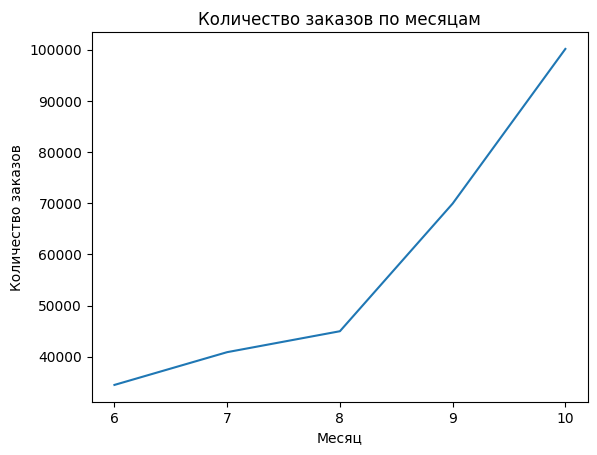

In [37]:
df_agg.plot(kind='line',
                 legend=False)

plt.title('Количество заказов по месяцам')
plt.ylabel('Количество заказов')
plt.xlabel('Месяц')
plt.xticks(ticks=range(6, 11), labels=range(6, 11))
plt.show()

In [38]:
df_agg.reset_index()

,month,order_id
0,6,34486
1,7,40890
2,8,44979
3,9,69921
4,10,100147


In [39]:
df_agg_1 = df_m.groupby('season')['order_id'].count().reset_index()

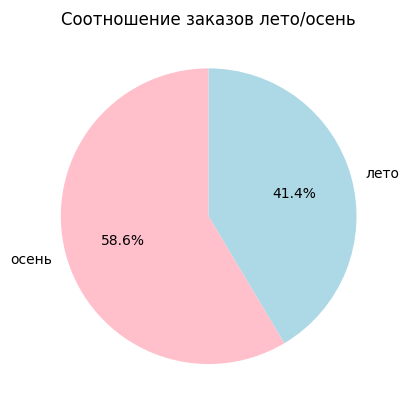

In [40]:
df_m['season'].value_counts().plot(kind='pie',
                                    title='Соотношение заказов лето/осень',
                                    legend=False,
                                    ylabel='',
                                    autopct='%1.1f%%',
                                    startangle=90,
                                    colors=['pink', 'lightblue'])
plt.show()

In [41]:
df_agg_1

,season,order_id
0,лето,120355
1,осень,170068


#### К концу октября наблюдается повышение активности и рост заказов с 33198 заказов до 99000 в конце октября. За два месяца осени (сентябрь и октябрь) соотношение заказов к летнему сезону 40,5%/59,5%.   Возможно это связано с тем,что клиенты осенью более активно проводят время на сервисе. Летом время от пусков.

In [42]:
df_group = df_m.groupby(['season','event_type_main']).agg({'order_id': 'count'}).reset_index()

In [43]:
total_orders_per_season = df_group.groupby('season')['order_id'].transform('sum')
df_group['share'] = df_group['order_id'] / total_orders_per_season

df_pivot = df_group.pivot(index='event_type_main', columns='season', values=['order_id','share']).fillna(0)
df_pivot

order_id              share          
season              лето    осень      лето     осень
event_type_main                                      
выставки          2417.0   2437.0  0.020082  0.014330
другое           32508.0  33222.0  0.270101  0.195345
концерты         51535.0  63726.0  0.428192  0.374709
спорт             3011.0  18887.0  0.025018  0.111056
стендап           6401.0   6992.0  0.053184  0.041113
театр            24207.0  43093.0  0.201130  0.253387
ёлки               276.0   1711.0  0.002293  0.010061

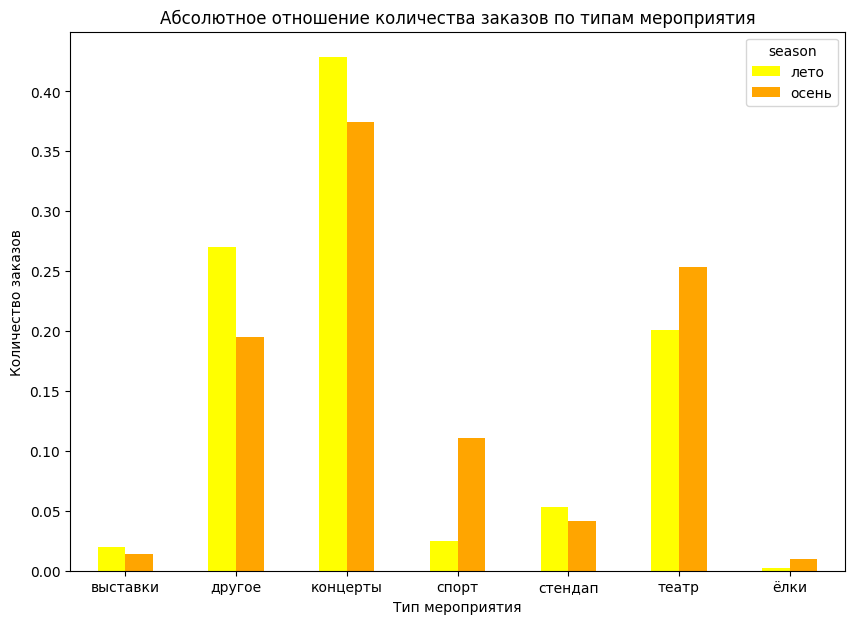

In [44]:
colors = ['yellow','orange']
df_pivot['share'].plot(kind='bar',
            title='Абсолютное отношение количества заказов по типам мероприятия',
            legend=True,
            ylabel='Количество заказов',
            xlabel='Тип мероприятия',
            rot=0, color = colors,
            figsize=(10,7))
plt.show()

Наибольшей популярностью пользуются концерты и  театры. Их количесво заказов ближе к осени растет. Наибольшая разница в росте видна в спортивных мероприятиях.

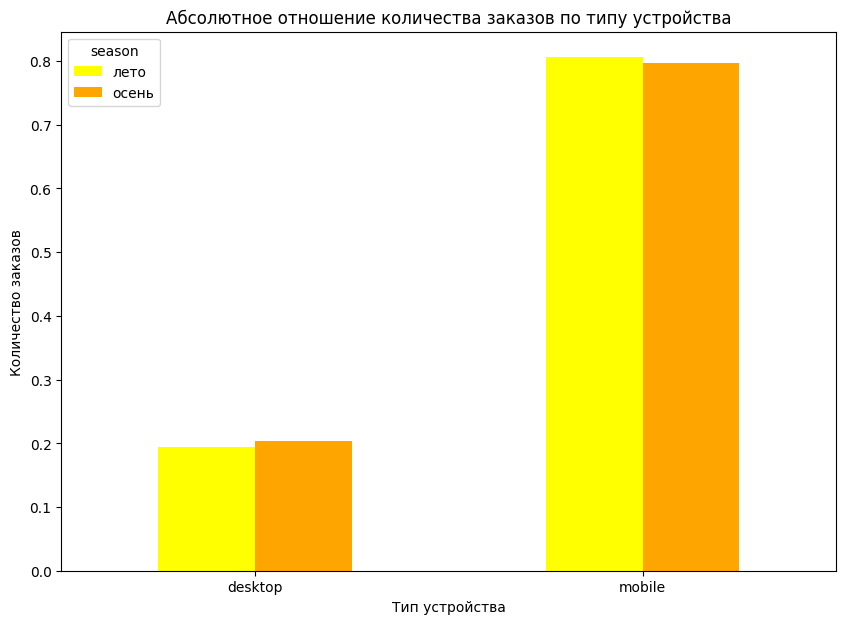

In [45]:
df_group_1 = df_m.groupby(['season','device_type_canonical']).agg({'order_id': 'count'}).reset_index()
total_orders_per = df_group_1.groupby('season')['order_id'].transform('sum')
df_group_1['share_1'] = df_group_1['order_id'] / total_orders_per

df_pivot_1 = df_group_1.pivot(index='device_type_canonical', columns='season', values=['order_id','share_1']).fillna(0)

colors = ['yellow','orange']
df_pivot_1['share_1'].plot(kind='bar',
            title='Абсолютное отношение количества заказов по типу устройства',
            legend=True,
            ylabel='Количество заказов',
            xlabel='Тип устройства',
            rot=0, color=colors,
            figsize=(10,7))
plt.show()

Наиболее популярным типом устройста заказорв являются мобильные телефоны.

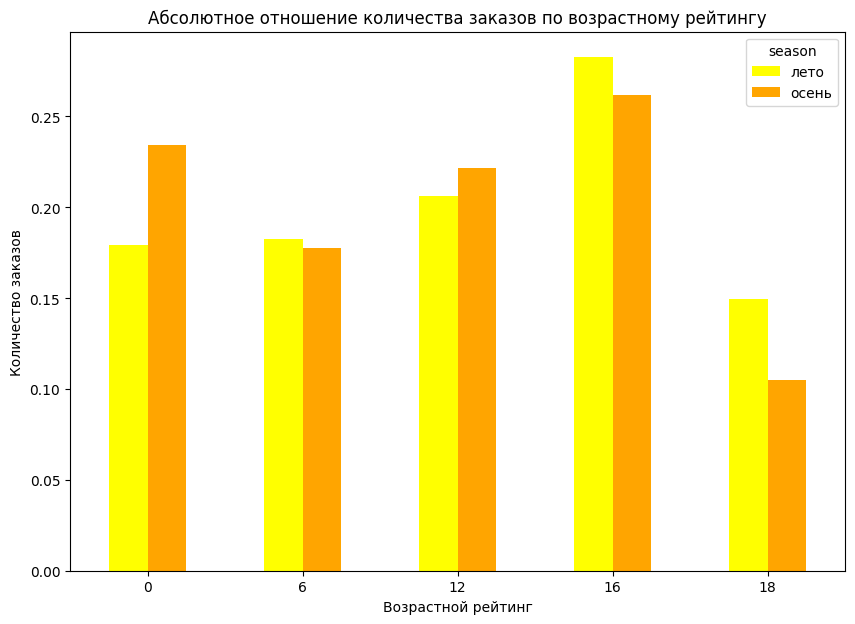

In [46]:
df_group_2 = df_m.groupby(['season','age_limit']).agg({'order_id': 'count'}).reset_index()
total_orders = df_group_2.groupby('season')['order_id'].transform('sum')
df_group_2['share_2'] = df_group_2['order_id'] / total_orders

df_pivot_2 = df_group_2.pivot(index='age_limit', columns='season', values=['order_id','share_2']).fillna(0)

colors = ['yellow','orange']

df_pivot_2['share_2'].plot(kind='bar',
            title='Абсолютное отношение количества заказов по возрастному рейтингу',
            legend=True,
            ylabel='Количество заказов',
            xlabel='Возрастной рейтинг',
            rot=0, color = colors,
            figsize=(10,7))
plt.show()

In [47]:
df_rev_one = df_m.groupby(['season','event_type_main']).agg({'one_ticket_revenue_rub': 'mean'}).reset_index()
df_rev_one

,season,event_type_main,one_ticket_revenue_rub
0,лето,выставки,86.388607
1,лето,другое,85.577471
2,лето,концерты,445.048239
3,лето,спорт,58.500059
4,лето,стендап,227.620964
5,лето,театр,222.618657
6,лето,ёлки,276.388228
7,осень,выставки,91.066619
8,осень,другое,81.392161
9,осень,концерты,297.349678


<Figure size 1600x800 with 0 Axes>

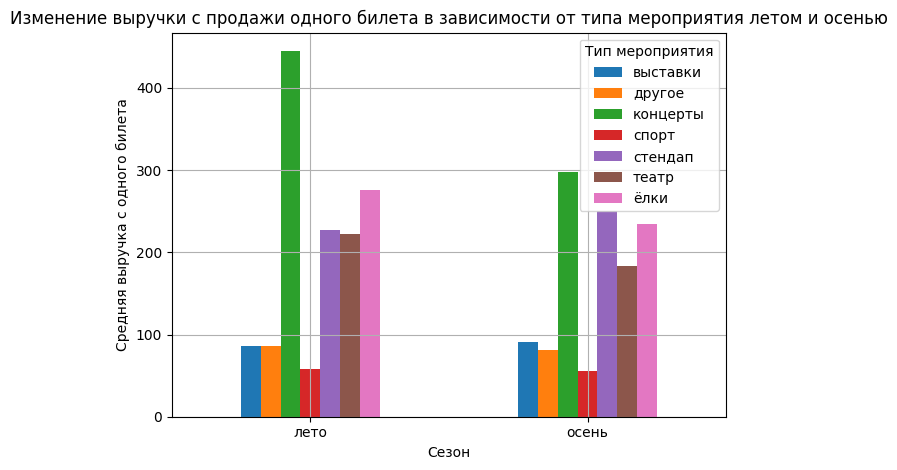

In [48]:
df_p = df_rev_one.pivot(index='season', columns='event_type_main', values='one_ticket_revenue_rub').fillna(0)
plt.figure(figsize=(16, 8))
df_p.plot(kind='bar')
plt.title('Изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью')
plt.xlabel('Сезон')
plt.ylabel('Средняя выручка с одного билета')
plt.xticks(rotation=0)
plt.grid()
plt.legend(title='Тип мероприятия')
plt.tight_layout()
plt.show()

Выручка с продажи одного билета летом выше с типа мероприятия концерты,так же как и осенью.

<Figure size 1600x800 with 0 Axes>

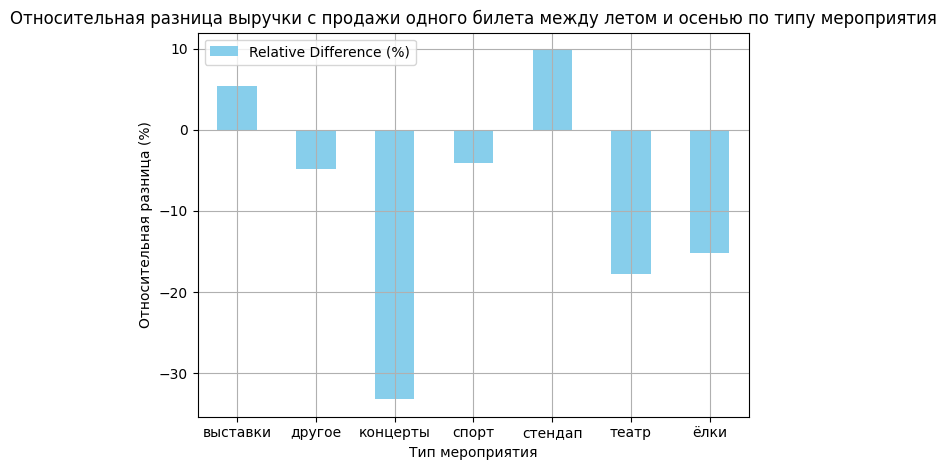

In [49]:
relative_difference = (df_p.loc['осень'] - df_p.loc['лето']) / df_p.loc['лето'] * 100

df_relative = pd.DataFrame(relative_difference, columns=['Relative Difference (%)'])

plt.figure(figsize=(16, 8))
df_relative.plot(kind='bar', color='skyblue')
plt.title('Относительная разница выручки с продажи одного билета между летом и осенью по типу мероприятия')
plt.xlabel('Тип мероприятия')
plt.ylabel('Относительная разница (%)')
plt.xticks(rotation=0)
plt.grid()
plt.tight_layout()
plt.show()

In [50]:
relative_difference

,0
event_type_main,
выставки,5.415080
другое,-4.890668
концерты,-33.187090
спорт,-4.092631
стендап,9.815835
театр,-17.781696
ёлки,-15.159743


In [51]:
df_one = df_rev_one.groupby('season').agg({'one_ticket_revenue_rub': 'mean'}).reset_index()
df_one

,season,one_ticket_revenue_rub
0,лето,200.306032
1,осень,170.485708


In [52]:
summer = df_one.loc[df_one['season'] == 'лето', 'one_ticket_revenue_rub'].values[0]
autumn = df_one.loc[df_one['season'] == 'осень', 'one_ticket_revenue_rub'].values[0]
df_one['repl'] = ((autumn - summer) / summer) * 100

print(df_one.reset_index())

   index season  one_ticket_revenue_rub       repl
0      0   лето              200.306032 -14.887382
1      1  осень              170.485708 -14.887382


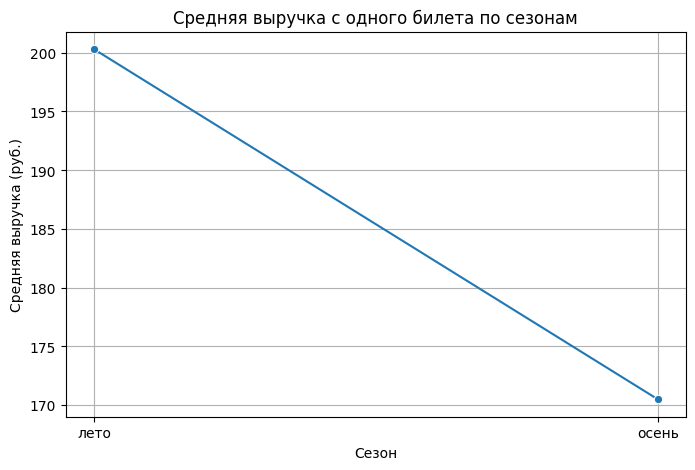

In [53]:
plt.figure(figsize=(8, 5))
sns.lineplot(x='season', y='one_ticket_revenue_rub', data=df_one, marker='o')
plt.title('Средняя выручка с одного билета по сезонам')
plt.xlabel('Сезон')
plt.ylabel('Средняя выручка (руб.)')
plt.grid()
plt.show()

Наблюдается изменение стоимости с одного билета осенью по сравнению с летом. Средняя выручка с одного билета снизилась на 16%.

### Вывод:   по анализу данных наблюдается рост количекства закзов ближе к осени. Но так же заметна динамика снижения средней выручки с продажи одного билета практически во всех категориях мероприятия вдвое.

#### Осенняя активность пользователей

In [54]:
df_m_aut = df_m[df_m['season']=='осень'].copy()

In [55]:
pivot_sales = pd.pivot_table(df_m_aut,
                             index="created_dt_msk",
                             values=["user_id","order_id","one_ticket_revenue_rub"],
                             aggfunc={"user_id":"nunique","order_id":"count","one_ticket_revenue_rub":'mean'})
pivot_sales['user_id'] = pd.to_numeric(pivot_sales['user_id'], errors='coerce')
pivot_sales['orders_per_user'] = pivot_sales['order_id'] / pivot_sales['user_id']


print(pivot_sales)

                one_ticket_revenue_rub  order_id  user_id  orders_per_user
created_dt_msk                                                            
2024-09-01                  210.853196      1348      569         2.369069
2024-09-02                  215.066341      1391      580         2.398276
2024-09-03                   87.524934      5124      783         6.544061
2024-09-04                  209.365139      1783      687         2.595342
2024-09-05                  220.502994      1956      745         2.625503
...                                ...       ...      ...              ...
2024-10-27                  192.671614      2866     1039         2.758422
2024-10-28                  178.602909      2858      988         2.892713
2024-10-29                  192.775655      2887     1005         2.872637
2024-10-30                  196.940494      2960     1049         2.821735
2024-10-31                  156.386805      5988     1282         4.670827

[61 rows x 4 columns]


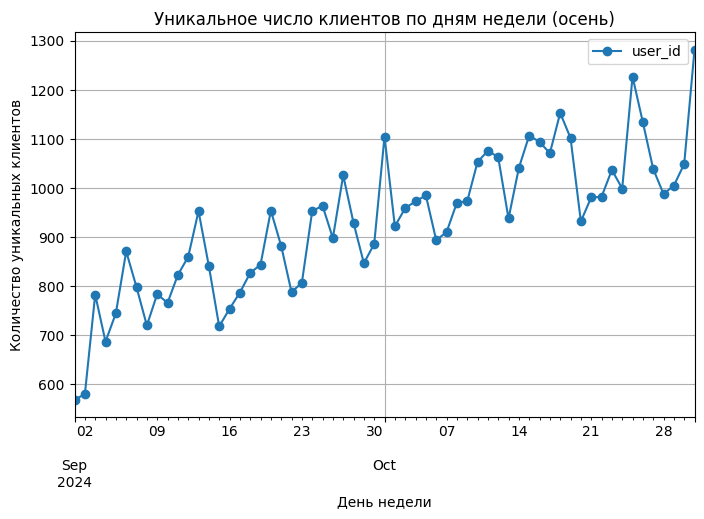

In [56]:
plt.figure(figsize=(8, 5))
pivot_sales['user_id'].plot(
               kind='line',
               marker='o',
               rot=0,
               legend=True,
               title=f'Уникальное число клиентов по дням недели (осень)'
)


plt.xlabel('День недели')
plt.ylabel('Количество уникальных клиентов')

plt.grid()


plt.show()

Осенью наблюдается рост клиентов. Пик приходится на 30 сентября, 31 октября.

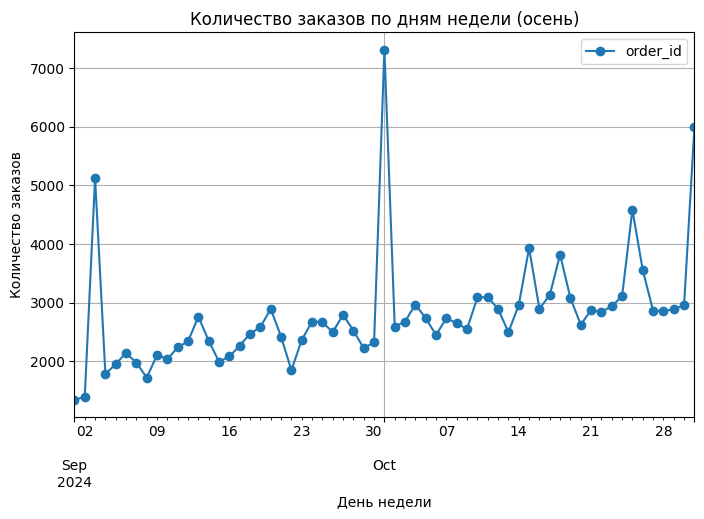

In [57]:
plt.figure(figsize=(8, 5))
pivot_sales['order_id'].plot(
               kind='line',
               marker='o',
               rot=0,
               legend=True,
               title=f'Количество заказов по дням недели (осень)'
)


plt.xlabel('День недели')
plt.ylabel('Количество заказов')

plt.grid()


plt.show()

Рост заказов наблюдается так же в конце каждого осеннего месяца.

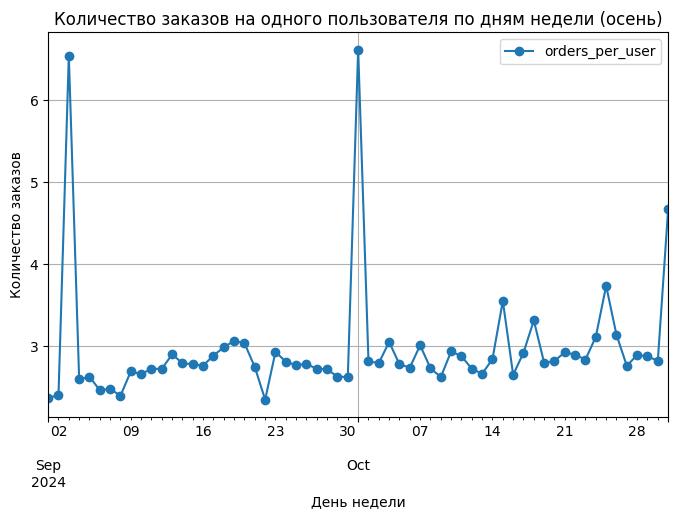

In [58]:
plt.figure(figsize=(8, 5))
pivot_sales['orders_per_user'].plot(
               kind='line',
               marker='o',
               rot=0,
               legend=True,
               title=f'Количество заказов на одного пользователя по дням недели (осень)'
)


plt.xlabel('День недели')
plt.ylabel('Количество заказов')

plt.grid()


plt.show()

Среднее количество заказов на одного пользователя так же растет к концу каждого месяца.

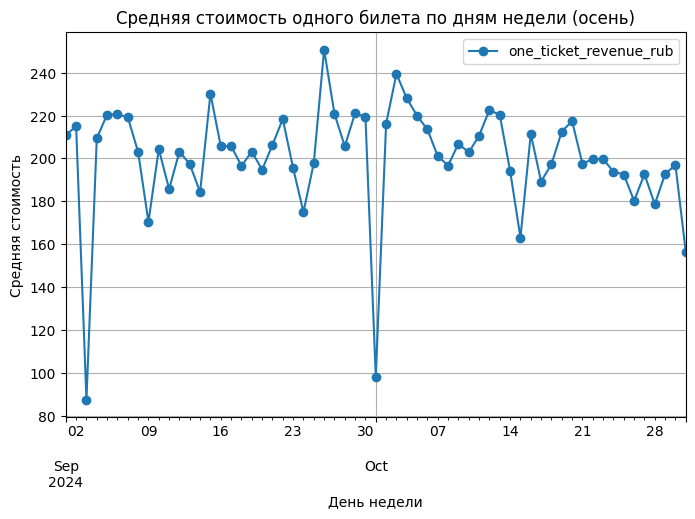

In [59]:
plt.figure(figsize=(8, 5))
pivot_sales['one_ticket_revenue_rub'].plot(
               kind='line',
               marker='o',
               rot=0,
               legend=True,
               title=f'Средняя стоимость одного билета по дням недели (осень)'
)


plt.xlabel('День недели')
plt.ylabel('Средняя стоимость')

plt.grid()


plt.show()

Средняя стоимость одного билета в конце каждого осеннего месяца самые низкие позиции.

  is_weekend  unique_users  total_orders
0    Weekday         13275        128959
1    Weekend          7198         41109


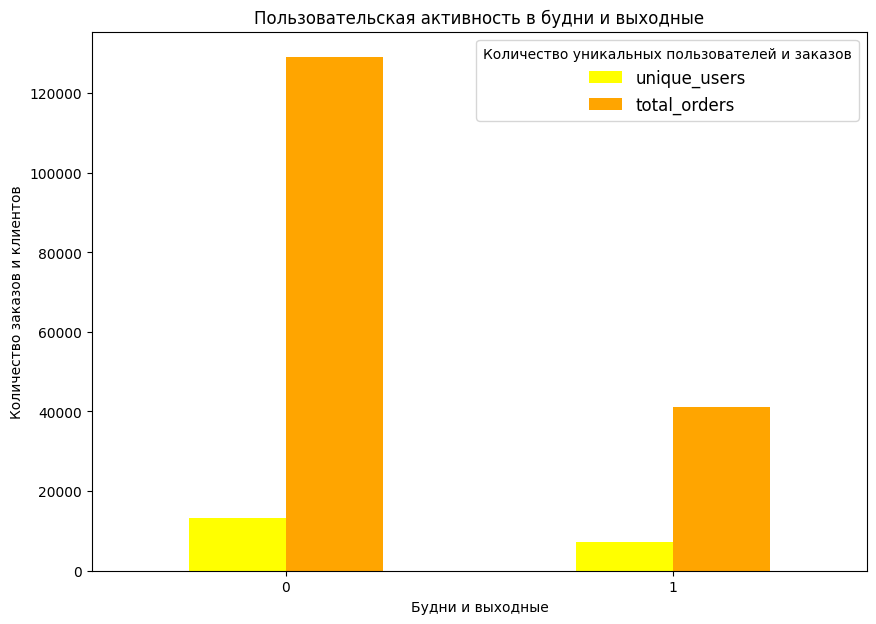

In [60]:
df_m_aut = df_m_aut.copy()
df_m_aut['created_dt_msk'] = pd.to_datetime(df_m_aut['created_dt_msk'])

df_m_aut['day_of_week'] = df_m_aut['created_dt_msk'].dt.day_name()

df_m_aut['is_weekend'] = df_m_aut['day_of_week'].isin(['Saturday', 'Sunday'])

activity_comparison = df_m_aut.groupby('is_weekend').agg(
    unique_users=('user_id', 'nunique'),
    total_orders=('order_id', 'count')
).reset_index()

activity_comparison['is_weekend'] = activity_comparison['is_weekend'].map({True: 'Weekend', False: 'Weekday'})

print(activity_comparison)

activity_comparison.plot(kind='bar',
            title='Пользовательская активность в будни и выходные',
            legend=True,
            ylabel='Количество заказов и клиентов',
            xlabel='Будни и выходные',
            rot=0, color=colors,
            figsize=(10,7))
plt.legend(loc='upper right', fontsize='large', title='Количество уникальных пользователей и заказов', title_fontsize='medium')
plt.show()

Количество заказов в будни выше,чем в выходные.

#### Промежуточный вывод : по предварительному анализу мы видим рост пользовательской активности,рост закзов,рост среднего числа заказов на одного пользователя в осенние месяцы. наиболее сильный рост фиксируется в конце каждого месяца в последний день. Но средняя стоимость одного билета в данные дни самая маленькая. Могу предположить,чт о на сервисе действует какая-нибудь акция в последний день месяца и стоимость со скидками самая маленькая,что вызывает ажиотаж среди пользователей.

### Популярные события и партнёры

In [61]:
df_region = df_m_aut.groupby('region_name').agg(unique_event_id=('event_id', 'nunique'),total_orders=('order_id', 'count')).reset_index()
orders = df_region['total_orders'].sum()
df_region['share_unique_event_ids'] = df_region['unique_event_id'] / df_region['unique_event_id'].sum()
df_region['share_total_orders'] = df_region['total_orders'] / orders
df_region_sorted = df_region.sort_values(by='unique_event_id', ascending=False)
display(df_region_sorted.head(10))


,region_name,unique_event_id,total_orders,share_unique_event_ids,share_total_orders
23,Каменевский регион,3946,47495,0.247895,0.279271
59,Североярская область,2619,20836,0.164531,0.122516
75,Широковская область,803,8739,0.050446,0.051385
56,Светополянский округ,764,4839,0.047996,0.028453
51,Речиновская область,529,3575,0.033233,0.021021
60,Серебринская область,456,4477,0.028647,0.026325
76,Яблоневская область,432,4224,0.027139,0.024837
67,Тепляковская область,420,2488,0.026385,0.014629
11,Горицветская область,406,3235,0.025506,0.019022
63,Солнечноземская область,403,4232,0.025317,0.024884


In [62]:
df_organizers = df_m_aut.groupby('service_name').agg(unique_id=('event_id', 'nunique'),total_orders=('order_id', 'count'),total_revenue=('revenue','sum')).reset_index()

In [63]:
total_unique_events_organizers = df_organizers['unique_id'].sum()
total_orders_organizers = df_organizers['total_orders'].sum()
total_revenue_organizers = df_organizers['total_revenue'].sum()
df_organizers['share_unique_events'] = df_organizers['unique_id'] / total_unique_events_organizers
df_organizers['share_total_orders'] = df_organizers['total_orders'] / total_orders_organizers
df_organizers['share_total_revenue'] = df_organizers['total_revenue'] / total_revenue_organizers

In [64]:
df_organizer_sorted = df_organizers.sort_values(by='total_revenue', ascending=False)

In [65]:
df_organizer_sorted.head(10)

,service_name,unique_id,total_orders,total_revenue,share_unique_events,share_total_orders,share_total_revenue
3,Билеты без проблем,2852,32728,14979643.49,0.164428,0.192441,0.164707
24,Мой билет,1009,19660,12579247.31,0.058172,0.115601,0.138314
25,Облачко,1413,15616,12459031.35,0.081464,0.091822,0.136992
21,Лови билет!,3626,25870,10644433.05,0.209052,0.152116,0.117040
8,Весь в билетах,608,9642,10170589.26,0.035053,0.056695,0.111830
5,Билеты в руки,2472,25758,7713660.65,0.142519,0.151457,0.084815
19,Край билетов,194,3055,3202614.69,0.011185,0.017963,0.035214
34,Яблоко,538,3496,2831861.44,0.031018,0.020556,0.031137
26,Прачечная,728,5831,2647691.55,0.041972,0.034286,0.029112
30,Тебе билет!,859,3779,2223909.32,0.049524,0.022221,0.024453


#### Промежуточный вывод: наиболее популярным регионом по разнообразию мероприятий является     
    Горностепной регион.  
  - Общее количество заказов: 47387
  - Уникальные события: 3929
  - Доля уникальных событий: 24.84%
  - Доля общего количества заказов: 27.98%    
  
    Североярская область
  - Общее количество заказов: 20744
  - Уникальные события: 2603
  - Доля уникальных событий: 16.46%
  - Доля общего количества заказов: 12.25%    
  
  Наиболее активными партнерами являются:
  
    Билеты без проблем
  - Общее количество заказов: 2826
  - Уникальные события: 32351
  - Выручка: 14979724.05
  - Доля заказов: 19.73%
  - Доля выручки: 29.45%

    Мой билет
  - Общее количество заказов: 1009
  - Уникальные события: 19660
  - Выручка: 12579247.31
  - Доля заказов: 7.23%
  - Доля выручки: 24.45%

  Лидеры по количеству проданных билетов:    

- "Билеты без проблем" (2852 билета) и "Лови билет!" (3626 билетов) являются лидерами по количеству проданных билетов, что может свидетельствовать о высокой популярности этих организаторов.    
- "Мой билет" и "Облачко" также показывают значительные объемы продаж, но значительно ниже, чем у лидеров.    

  Выручка:   

- "Билеты без проблем" также лидирует по общей выручке (14,979,643.49), что подтверждает его успешность на рынке.   
- "Лови билет!" с выручкой 10,644,433.05 также демонстрирует хорошие результаты, что может быть связано с высоким количеством проданных билетов.    
- Сервис 'Билеты без проблем' составляет 16.44% от общей выручки, что делает его лидером среди всех организаторов.    

    Доля рынка:

- Доля уникальных мероприятий и доля заказов показывают, что "Лови билет!" имеет наибольшую долю уникальных мероприятий (0.209052), что может указывать на разнообразие предлагаемых событий.   
- "Билеты без проблем" и "Билеты в руки" также имеют значительные доли, что говорит о их активном участии на рынке.

## Статистический анализ данных

#### Сформулируем нулевую и альтернативную гипотезы:

Нулевая гипотеза (Н0): Среднее количество заказов на одного пользователя мобильного приложения не выше по сравнению с пользователями стационарных устройств.    

Альтернативная гипотеза (Н1): Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.

In [66]:
group_1 = df_m_aut[df_m_aut['device_type_canonical']=='mobile'].groupby('user_id')['order_id'].count()
group_2 = df_m_aut[df_m_aut['device_type_canonical']=='desktop'].groupby('user_id')['order_id'].count()

In [67]:
a = df_m_aut[df_m_aut['device_type_canonical']=='mobile']['user_id']
b = df_m_aut[df_m_aut['device_type_canonical']=='desktop']['user_id']
intersection = list(set(a) & set(b))
display(len(intersection))

3271

In [68]:
df_m_aut = df_m_aut[~df_m_aut['user_id'].isin(intersection)]

p_group = df_m_aut.groupby('device_type_canonical')['user_id'].agg('nunique').reset_index()

print(f'Распределение количества пользователей в двух группах после удаления дубликатов: \n{p_group}')

Распределение количества пользователей в двух группах после удаления дубликатов: 
  device_type_canonical  user_id
0               desktop     1633
1                mobile    10962


In [69]:
df_grp = df_m_aut.groupby('device_type_canonical').agg({'user_id': 'nunique'}).reset_index()
df_grp

,device_type_canonical,user_id
0,desktop,1633
1,mobile,10962


  Аргументация применения теста Манна-Уитни:    

- Непараметричность: Тест Манна-Уитни не требует, чтобы данные следовали нормальному распределению. Распределение данных у нас ненормальное.     

- Независимость выборок: наши выборки независимы друг от друга.     

- Малые выборки: Тест Манна-Уитни может быть использован для малых выборок, где применение параметрических тестов может быть неуместным из-за недостатка данных для проверки нормальности.    

- Устойчивость к выбросам: тест менее чувствителен к выбросам по сравнению с параметрическими тестами, такими как t-тест.У нас есть выбросы.       


In [70]:
alpha = 0.05
mw_test = mannwhitneyu(
    group_1,
    group_2,
    alternative='greater')
if mw_test.pvalue > alpha:
    print(f'pvalue={mw_test.pvalue} > {alpha}')
    print('Нулевая гипотеза находит подтверждение! Среднее количество заказов на одного пользователя мобильного приложения не выше по сравнению с пользователями стационарных устройств.')
else:
    print(f'pvalue={mw_test.pvalue} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения! Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.')

pvalue=1.2695779312133708e-07 < 0.05
Нулевая гипотеза не находит подтверждения! Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.


#### Сформулируем нулевую и альтернативную гипотезы:

Нулевая гипотеза (Н0): Среднее время между заказами пользователей мобильных приложений не выше по сравнению с пользователями стационарных устройств.        

Альтернативная гипотеза (Н1): Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

In [71]:
gr_1 = df_m_aut[df_m_aut['device_type_canonical']=='mobile']['days_since_prev']
gr_2 = df_m_aut[df_m_aut['device_type_canonical']=='desktop']['days_since_prev']

In [72]:
print(f'Количество NaN в мобильной группе: {gr_1.isnull().sum()}')
print(f'Количество NaN в настольной группе: {gr_2.isnull().sum()}')

Количество NaN в мобильной группе: 6725
Количество NaN в настольной группе: 1135


In [73]:
gr_1 = df_m_aut[df_m_aut['device_type_canonical'] == 'mobile']['days_since_prev'].dropna()
gr_2 = df_m_aut[df_m_aut['device_type_canonical'] == 'desktop']['days_since_prev'].dropna()
print(f'Размер группы мобильных после удаления NaN: {len(gr_1)}')
print(f'Размер группы настольных после удаления NaN: {len(gr_2)}')

Размер группы мобильных после удаления NaN: 24737
Размер группы настольных после удаления NaN: 2096


Обоснование выбора теста Манна-Уитни   

- Цель исследования: Целью исследования является сравнение средних значений переменной (времени между заказами) между двумя независимыми группами: пользователями мобильных устройств и пользователями стационарных устройств.   

- Тип данных: Переменная, days_since_prev, является порядковой или непрерывной. Тест Манна-Уитни подходит для анализа данных, которые могут не соответствовать нормальному распределению, что делает его хорошим выбором для анализа ранговых данных или данных с выбросами.   

- Независимость групп: Группы мобильных и стационарных пользователей являются независимыми, то есть данные одной группы не влияют на данные другой группы. Это соответствует предпосылке теста Манна-Уитни, который предназначен для сравнения двух независимых выборок.   

- Нормальность распределения: Тест Манна-Уитни не требует, чтобы данные были нормально распределены. Это делает его более подходящим выбором, если есть сомнения в нормальности распределения переменной days_since_prev, что может быть особенно актуально в реальных данных.   

- Равенство дисперсий: Тест Манна-Уитни не требует равенства дисперсий между группами, что делает его более гибким в ситуациях, когда дисперсии могут различаться. Это особенно важно, если размеры выборок различаются, как в нашем случае (24,737 в мобильной и 2,096 в стационарной группах).    

- Устойчивость к выбросам: Тест Манна-Уитни является непараметрическим и более устойчив к выбросам по сравнению с t-тестом. Это позволяет избежать искажений результатов, которые могут возникнуть из-за экстремальных значений в данных.    

- Размер выборки: В нашем случае достаточно данных в обеих группах, что позволяет получить надежные результаты. Тест Манна-Уитни может эффективно работать с большими выборками и обеспечивать статистическую мощность для выявления различий между группами.

In [74]:
df_m_aut['days_since_prev'].describe()

,days_since_prev
count,26833.000000
mean,14.141468
std,26.345835
min,0.000000
25%,0.000000
50%,1.000000
75%,15.000000
max,148.000000


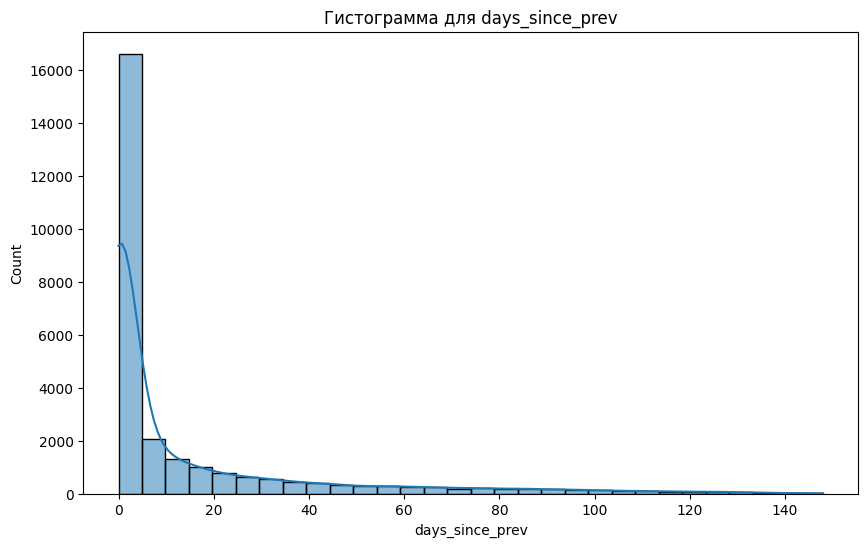

In [75]:
data = df_m_aut['days_since_prev'].dropna()

plt.figure(figsize=(10, 6))
sns.histplot(data, bins=30, kde=True)
plt.title('Гистограмма для days_since_prev')
plt.show()


In [76]:
mean = data.mean()
std_dev = data.std()

z_scores = (data - mean) / std_dev

outliers_z = data[(z_scores > 3) | (z_scores < -3)]

print("Выбросы по методу Z-оценки:")
print(outliers_z)

Выбросы по методу Z-оценки:
273       134.0
435       122.0
1516      128.0
1527      108.0
2814      137.0
          ...  
289449    113.0
289478     94.0
289772     95.0
289902     99.0
290371    139.0
Name: days_since_prev, Length: 806, dtype: float64


In [77]:

statistic, p_value = levene(gr_1, gr_2)

# Вывод результатов
print(f"Статистика теста Левена: {statistic}")
print(f"P-значение: {p_value}")

Статистика теста Левена: 54.37199442095826
P-значение: 1.7070921521101914e-13


In [78]:
alpha = 0.05

# Применяем тест Манна — Уитни
stat_mw, p_value_mw = mannwhitneyu(
    gr_1,
    gr_2,
    alternative='greater'
)

if p_value_mw > alpha:
    print(f'pvalue={p_value_mw} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!Среднее время между заказами пользователей мобильных приложений не выше по сравнению с пользователями стационарных устройств.')
else:
    print(f'pvalue={p_value_mw} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.')

pvalue=1.8025445252928065e-08 < 0.05
Нулевая гипотеза не находит подтверждения!Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.


## Общий вывод и рекомендации

Мы работали с данными в виде 3 датасетов: `final_tickets_orders_df.csv`,`final_tickets_events_df.csv`,`final_tickets_tenge_df.csv`.     

- `final_tickets_orders_df.csv` - датасет включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных.     

- `final_tickets_events_df.csv`-содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия.    

- `final_tickets_tenge_df.csv`- с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге.


Рост активности пользователей: Наблюдается значительное увеличение количества заказов с 33,198 до 99,000 к концу октября, что указывает на рост пользовательской активности в осенний период. Это может быть связано с тем, что осенью клиенты более активно используют сервис, особенно для посещения концертов и театров.    

Сезонные колебания: Соотношение заказов между осенью и летом (40,5% к 59,5%) подтверждает, что осень является важным сезоном для бизнеса, несмотря на то, что летний период традиционно может быть более активным из-за отпусков.    

Изменение выручки: Средняя выручка с одного билета снизилась на 16% осенью по сравнению с летом, что может указывать на изменение ценовой политики или на наличие акций и скидок, особенно в последние дни месяца, когда фиксируется наибольший рост заказов.    

Разница в типах мероприятий: Наибольший рост заказов наблюдается в спортивных мероприятиях, что может свидетельствовать о повышенном интересе к спорту в осенний период. Концерты и театры остаются наиболее популярными, но их рост менее выражен.     

Устройства для заказов: Пользователи мобильных приложений показывают более высокое среднее количество заказов по сравнению с пользователями стационарных устройств, что может указывать на удобство и доступность мобильных платформ.    

География и организаторы: Горностепной регион и Солнечноземская область являются наиболее активными регионами по количеству мероприятий, а организаторы, такие как "Билеты без проблем", "Мой билет" и "Облачко", занимают лидирующие позиции на рынке.       
  
Рекомендации    
Акции и скидки: Учитывая, что наибольший рост заказов наблюдается в последние дни месяца, рекомендуется продолжать и развивать акции и скидки в этот период, чтобы стимулировать спрос и увеличить выручку.    

Улучшение мобильного приложения: Поскольку пользователи мобильных устройств показывают более высокую активность, стоит инвестировать в улучшение функциональности и удобства мобильного приложения, чтобы привлечь еще больше пользователей.    

Анализ предпочтений пользователей: Рекомендуется провести более глубокий анализ предпочтений пользователей по типам мероприятий и регионам, чтобы лучше адаптировать предложения и маркетинговые стратегии.   

Мониторинг ценовой политики: Следует внимательно следить за изменениями в средней стоимости билетов и выручке, чтобы своевременно реагировать на изменения в спросе и предложении.    

Расширение географии мероприятий: Учитывая активность в определенных регионах, стоит рассмотреть возможность расширения предложения мероприятий в менее активных регионах, чтобы увеличить охват и привлечь новых клиентов.    

Проведение дополнительных исследований: Рекомендуется провести дополнительные исследования для проверки гипотез о влиянии различных факторов на пользовательскую активность и выручку, чтобы более точно настраивать бизнес-стратегии.     

По проверки гипотез делаем выводы:    
1) Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.  

2) Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.